In [1]:
# !ln -s /usr/lib/x86_64-linux-gnu/libcublas.so.8.0 /usr/lib/x86_64-linux-gnu/libcublas.so
# !pip install paddlepaddle-gpu==0.14.0.post85
# !ldconfig
# !pip install visualdl protobuf==3.5.1

In [2]:
import numpy as np
import paddle.fluid as fluid
import paddle
from paddle.fluid.debugger import draw_block_graphviz
import matplotlib.pyplot as plt
from visualdl import LogWriter

## Generator &  Discriminator

In [3]:
# 噪声维度
z_dim = 100

In [4]:
# 生成器 Generator
# z.shape == (N, C, 1, 1)
def G(z, name="G"):
   
    with fluid.unique_name.guard(name + "/"):
        y = z
        
        y = fluid.layers.fc(y, size=1024, act='tanh')
        y = fluid.layers.fc(y, size=128 * 7 * 7)
        y = fluid.layers.batch_norm(y, act='tanh')
        y = fluid.layers.reshape(y, shape=(-1, 128, 7, 7))

        y = fluid.layers.image_resize(y, scale=2)
        y = fluid.layers.conv2d(y, num_filters=64, filter_size=5, padding=2, act='tanh')

        y = fluid.layers.image_resize(y, scale=2)
        y = fluid.layers.conv2d(y, num_filters=1, filter_size=5, padding=2, act='tanh')

    return y

In [5]:
# 判别器 Discriminator
def D(images, name="D"):
    def conv_bn(input, num_filters, filter_size):
        y = fluid.layers.conv2d(
            input,
            num_filters=num_filters, 
            filter_size=filter_size,
            padding=0,
            stride=1,
            bias_attr=False)
        y = fluid.layers.batch_norm(y)
        y = fluid.layers.leaky_relu(y)
        return y

    with fluid.unique_name.guard(name + "/"):
        y = images
        
        y = conv_bn(y, num_filters=32, filter_size=3)
        y = fluid.layers.pool2d(y, pool_size=2, pool_stride=2)
        
        y = conv_bn(y, num_filters=64, filter_size=3)
        y = fluid.layers.pool2d(y, pool_size=2, pool_stride=2)
        
        y = conv_bn(y, num_filters=128, filter_size=3)
        y = fluid.layers.pool2d(y, pool_size=2, pool_stride=2)
        
        y = fluid.layers.fc(y, size=1)

    return y

## Programs

In [6]:
# 三个训练Program
# train_d_fake、train_d_real训练D，可合成一个
train_d_fake = fluid.Program()
train_d_real = fluid.Program()

# train_g训练G
train_g = fluid.Program()

# 共享的初始化Program
startup = fluid.Program()

In [7]:
## 从program获取prefix开头的参数名字
def get_params(program, prefix):
    all_params = program.global_block().all_parameters()
    return [t.name for t in all_params if t.name.startswith(prefix)]

In [8]:
# 训练D识别真实图片
with fluid.program_guard(train_d_real, startup):
    # 真实图片输入，Label为1
    real = fluid.layers.data('img', shape=[1, 28, 28])
    ones = fluid.layers.fill_constant_batch_size_like(real, shape=[-1, 1], dtype='float32', value=1)
    
    # D判断真实图片的概率
    p_real = D(real)
    # 损失
    real_loss = fluid.layers.mean(fluid.layers.sigmoid_cross_entropy_with_logits(p_real, ones))
    
    # 获取D的参数
    d_params = get_params(train_d_real, "D")
    
    optimizer = fluid.optimizer.Adam(learning_rate=0.0002)
    # 只训练D的参数
    optimizer.minimize(real_loss, parameter_list=d_params)
    
    print(d_params)

['D/D/conv2d_0.w_0', 'D/D/batch_norm_0.w_0', 'D/D/batch_norm_0.b_0', 'D/D/batch_norm_0.w_1', 'D/D/batch_norm_0.w_2', 'D/D/conv2d_1.w_0', 'D/D/batch_norm_1.w_0', 'D/D/batch_norm_1.b_0', 'D/D/batch_norm_1.w_1', 'D/D/batch_norm_1.w_2', 'D/D/conv2d_2.w_0', 'D/D/batch_norm_2.w_0', 'D/D/batch_norm_2.b_0', 'D/D/batch_norm_2.w_1', 'D/D/batch_norm_2.w_2', 'D/D/fc_0.w_0', 'D/D/fc_0.b_0']


In [9]:
# 训练D识别G生成的图片为假图片
with fluid.program_guard(train_d_fake, startup):
    # 噪声
    z = fluid.layers.data(name='z', shape=[z_dim, 1, 1])
    
    # G生成图片，Label为0
    p_fake = D(G(z))
    zeros = fluid.layers.fill_constant_batch_size_like(z, shape=[-1, 1], dtype='float32', value=0)
    
    # 损失
    fake_loss = fluid.layers.mean(fluid.layers.sigmoid_cross_entropy_with_logits(p_fake, zeros))
    
    # 获取D的参数
    d_params = get_params(train_d_fake, "D")

    optimizer = fluid.optimizer.Adam(learning_rate=0.0002)
    optimizer.minimize(fake_loss, parameter_list=d_params)

In [10]:
# 训练G生成符合D标准的“真实”图片
with fluid.program_guard(train_g, startup):
    # 噪声
    z = fluid.layers.data(name='z', shape=[z_dim, 1, 1])
    # 生成图片
    fake = G(z)
    infer_program = train_g.clone(for_test=True)
    # 生成图片为真实图片的概率，Label为1
    p = D(fake)
    ones = fluid.layers.fill_constant_batch_size_like(z, shape=[-1, 1], dtype='float32', value=1)
    # 损失
    g_loss = fluid.layers.mean(fluid.layers.sigmoid_cross_entropy_with_logits(p, ones))
    
    # 获取G的参数
    g_params = get_params(train_g, "G")
    
    # 只训练G
    optimizer = fluid.optimizer.Adam(learning_rate=0.0002)
    optimizer.minimize(g_loss, parameter_list=g_params)
    
    print(g_params)

['G/G/fc_0.w_0', 'G/G/fc_0.b_0', 'G/G/fc_1.w_0', 'G/G/fc_1.b_0', 'G/G/batch_norm_0.w_0', 'G/G/batch_norm_0.b_0', 'G/G/batch_norm_0.w_1', 'G/G/batch_norm_0.w_2', 'G/G/conv2d_0.w_0', 'G/G/conv2d_0.b_0', 'G/G/conv2d_1.w_0', 'G/G/conv2d_1.b_0']


## Train

In [11]:
logdir = "./tmp"
logwriter = LogWriter(logdir, sync_cycle=10)

with logwriter.mode("train") as writer:
    d_loss_writer = writer.scalar("d_loss")
    d_fake_loss_writer = writer.scalar("d_fake_loss")
    d_real_loss_writer = writer.scalar("d_real_loss")
    g_loss_writer = writer.scalar("g_loss")

In [12]:
def show_image_grid(images, epoch=None): # images.shape = (64, 1, 28, 28)
    fig = plt.figure(figsize=(5, 5))
    fig.suptitle("Epoch {}".format(epoch))
    gs = plt.GridSpec(8, 8)
    gs.update(wspace=0.05, hspace=0.05)

    for i, image in enumerate(images[:64]):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(image[0], cmap='Greys_r')
    plt.show()

In [13]:
batch_size = 128
step_per_epoch = 60000 / batch_size

# 噪声生成
def z_reader():
    while True:
        yield np.random.normal(0.0, 1.0, (z_dim, 1, 1)).astype('float32')

In [14]:
# MNIST数据集，不使用label
def mnist_reader(reader):
    def r():
        for img, label in reader():
            yield img.reshape(1, 28, 28)
    return r

mnist_generator = paddle.batch(
    paddle.reader.shuffle(mnist_reader(paddle.dataset.mnist.train()), 1024), batch_size=batch_size)
z_generator = paddle.batch(z_reader, batch_size=batch_size)()

In [15]:
place = fluid.CUDAPlace(0) if fluid.core.is_compiled_with_cuda() else fluid.CPUPlace()
exe = fluid.Executor(place)
exe.run(startup)

[]

In [16]:
# 测试噪声
np.random.seed(0)
test_z = np.array(next(z_generator))

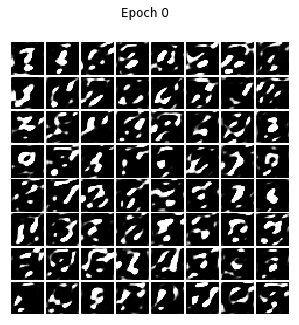

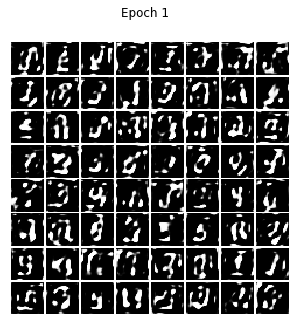

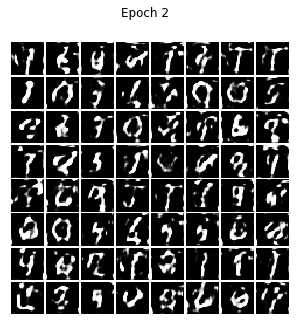

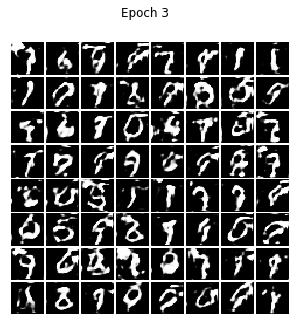

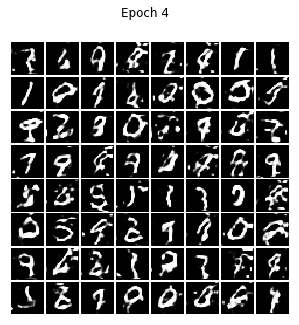

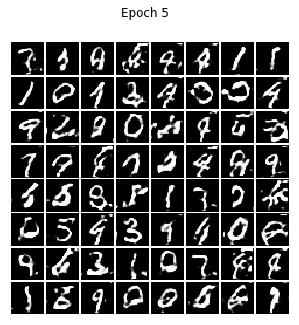

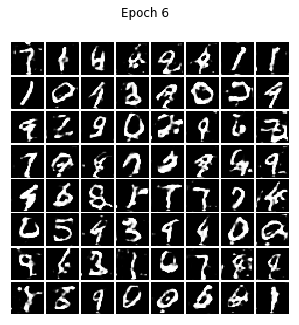

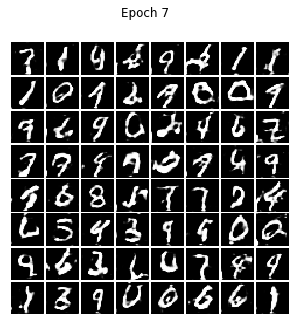

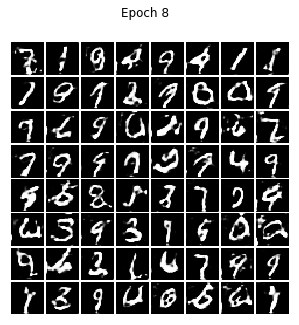

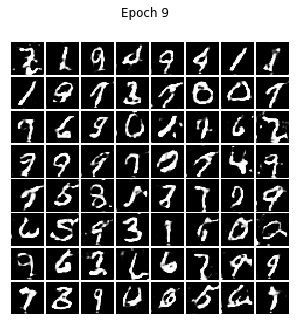

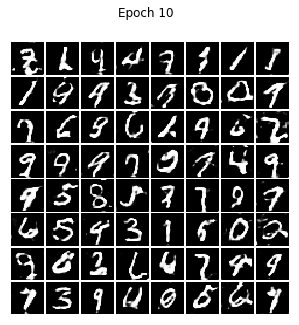

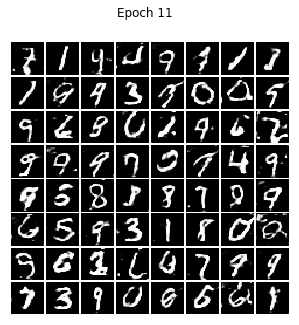

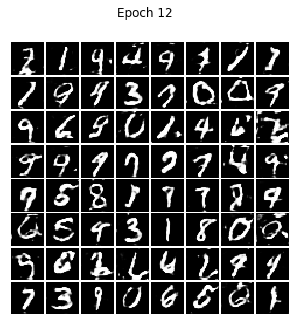

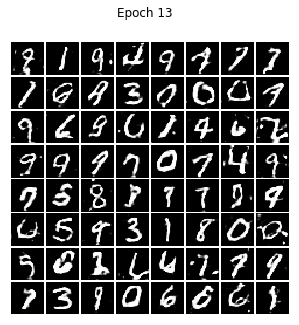

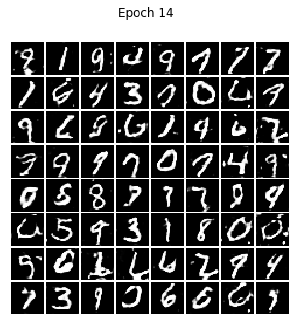

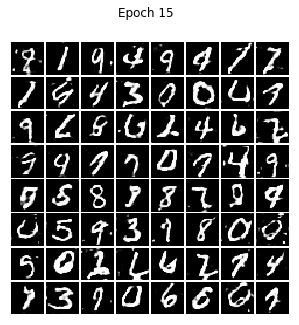

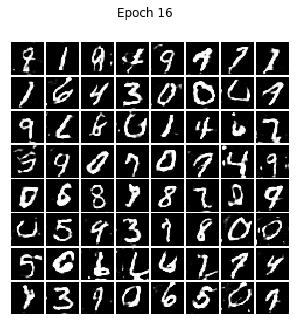

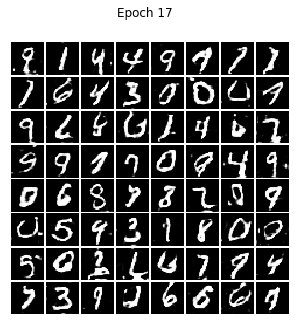

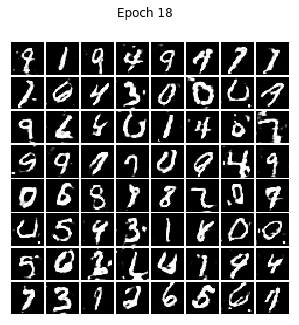

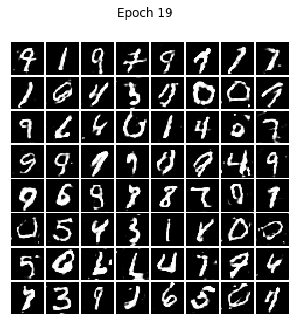

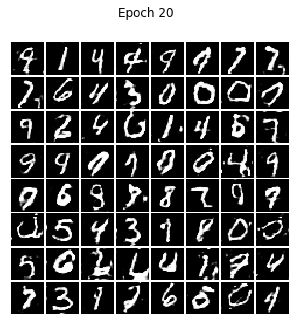

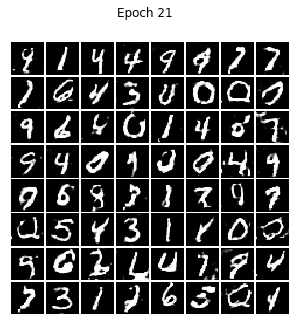

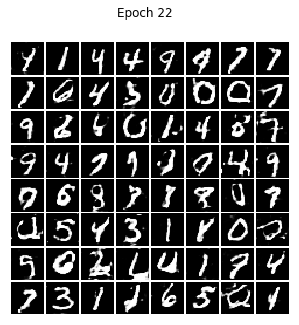

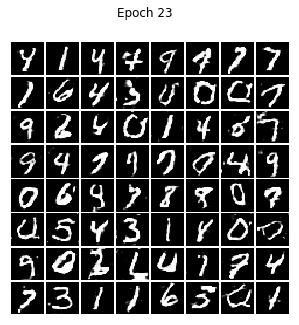

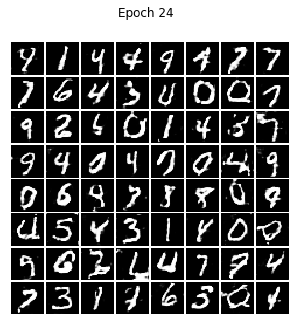

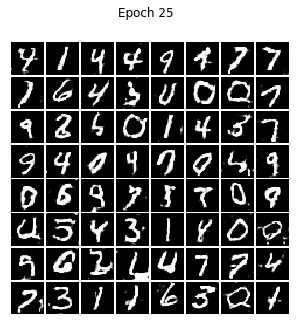

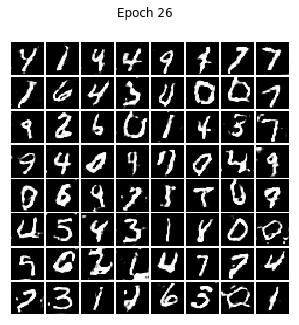

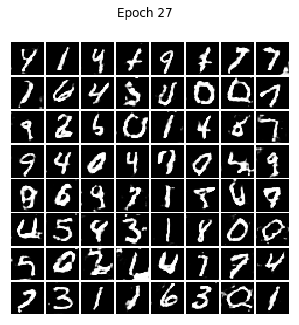

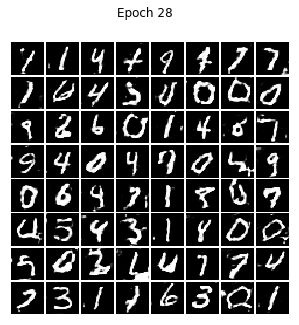

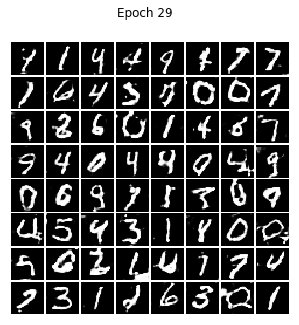

In [17]:
for epoch in range(30):

    for i, real_image in enumerate(mnist_generator()):
        step = epoch * step_per_epoch + i

        # 训练D识别真实图片
        r_fake = exe.run(train_d_fake, fetch_list=[fake_loss], feed={
            'z': np.array(next(z_generator))
        })
        d_fake_loss_writer.add_record(step, np.mean(r_fake))
        
        ## 训练D识别G生成的图片为假图片
        r_real = exe.run(train_d_real, fetch_list=[real_loss], feed={
            'img': np.array(real_image)
        })
        d_real_loss_writer.add_record(step, np.mean(r_real))
        d_loss_writer.add_record(step, np.mean(r_fake) + np.mean(r_real))
        
        ## 训练G生成符合D标准的“真实”图片
        r_g = exe.run(train_g, fetch_list=[g_loss], feed={
            'z': np.array(next(z_generator))
        })
        g_loss_writer.add_record(step, np.mean(r_g))
        
    # 测试
    r_i = exe.run(infer_program, fetch_list=[fake], feed={
        'z': test_z
    })
    show_image_grid(r_i[0], epoch)